# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
### Import Libraries

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

import pickle
%matplotlib inline

### Training Data Preparation

In [2]:
#File Read
cars = glob.glob('C:/CarND/vehicles/**/*.png')
nocars = glob.glob('C:/CarND/non-vehicles/**/*.png')

print("Number of car images: ",len(cars))
print("Number of non-car images: ",len(nocars))

images = []
for fname in cars:
    images.append(cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB))

for fname in nocars:
    images.append(cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB))
    
print("Total number of images: ",len(images))

#labels assigned
labels = np.concatenate([np.ones(len(cars)),np.zeros(len(nocars))])

#Random shuffle
X_data, y_data = shuffle(images, labels)


Number of car images:  8792
Number of non-car images:  8968
Total number of images:  17760


1.0


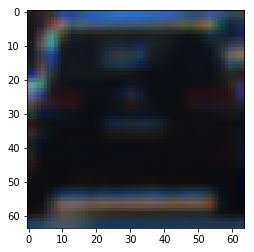

In [3]:
#Example car image
i = np.random.randint(1,len(cars),dtype='int')
plt.imshow(images[i])
print(labels[i])

0.0


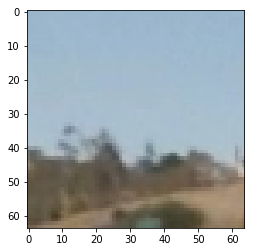

In [4]:
#Example non-car image
i = np.random.randint(len(cars),len(nocars),dtype='int')
plt.imshow(images[i])
print(labels[i])

In [5]:
del images
del labels

## Step 1: Histogram of Oriented Gradients (HOG) Feature Extraction

### Helper Functions

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), cspace='RGB'):
    if cspace=='gray':
        hist_features = np.histogram(img[:,:], bins=nbins, range=bins_range)
    else:
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
#Explore transform_sqrt later

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Hog Example

In [50]:
color_space = 'YCrCb'
pix_per_cell = 8
cell_per_block = 2
orient = 12
hog_channel = 'ALL'
hist = True
spat = True

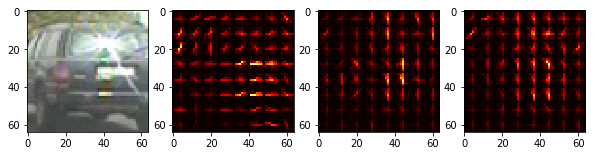

In [51]:
i = np.random.randint(1,len(X_data),dtype='int')
test_image = X_data[i]
test_image_conv = cv2.cvtColor(test_image, cv2.COLOR_RGB2YUV)
feature =[]
plt.subplots(1,4,figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(test_image)

for channel in range(test_image_conv.shape[2]):
    curr_feat, hog_image = get_hog_features(test_image_conv[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    feature.append(curr_feat)
    plt.subplot(1,4,channel+2)
    plt.imshow(hog_image, cmap = 'hot')

In [52]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, hist = True, spat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        curr_features = []
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        feature_image = (((feature_image) - 128.) / 128.)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False).ravel())       
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False).ravel()
        
        curr_features.append(np.ravel(hog_features))
        
        if spat == True:
            spat_size = (32,32)
            spat_features = bin_spatial(feature_image, size=spat_size)
            curr_features.append(spat_features)
        
        if hist == True:
            hist_bins = 64
            hist_range = (0,256)
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range, cspace=cspace)
            curr_features.append(hist_features)

        # Append the new feature vector to the features list
        features.append(np.concatenate(curr_features))
    
    # Return list of feature vectors
    return features

### Hog of dataset

In [53]:
features = extract_features(X_data, cspace=color_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist = hist, spat = spat)

print(len(features))      

17760


### Normalization

(10320,)


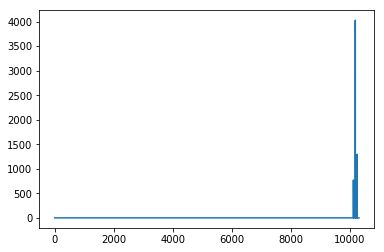

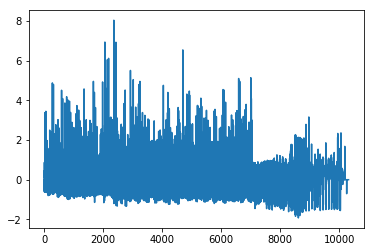

In [54]:
X = np.array(features).astype(np.float64)
print(X[5001].shape)
plt.plot(X[5001])
feature_scaler = StandardScaler().fit(X)
features_scaled = feature_scaler.transform(X)
plt.figure()
plt.plot(features_scaled[5001])

## Step 2: Classifier Training

### Train-Test Split

In [55]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_data, test_size=0.2, random_state=rand_state)

print("Number of training images: ", len(X_train))
print("Number of testing images: ", len(X_test))

Number of training images:  14208
Number of testing images:  3552


In [56]:
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [57]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.993


In [58]:
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  1.  1.  1.  0.]


### Dump Classifier and Parameters

In [59]:
#save variable on computer through pickle
training_parameters = {'svc': svc, 'feature_scaler': feature_scaler, 'orient': orient, 
                             'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 
                             'color_space': color_space, 'hog_channel': hog_channel, 'hist': hist, 'spat': spat}

with open("training_parameters.p", 'wb') as file:
    pickle.dump(training_parameters, file, protocol=pickle.HIGHEST_PROTOCOL)